# アニメの情報からカテゴリを予測する

予測するのに使う情報
- タイトル
- 説明



データの準備
==================

Kaggleにデータがあったので、以下のコマンドでダウンロードする
```bash
kaggle datasets download -d dbdmobile/myanimelist-dataset
```


In [31]:
%matplotlib inline

In [32]:
# データセットのダウンロード
!kaggle datasets download -d dbdmobile/myanimelist-dataset

^C
User cancelled operation


In [ ]:
!ls # ダウンロードしたファイルがあるかどうか確認

README.md		 pyproject.toml		requirements.lock
myanimelist-dataset.zip  requirements-dev.lock	src


In [ ]:
# ダウンロードしたデータを解答
import zipfile
import os
from pathlib import Path


DATASET_PATH = "data"

# すでにデータセットを格納するディレクトリがあるかどうか確認
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

# データを解凍
if not os.path.exists(Path(DATASET_PATH, "anime-dataset-2023.csv").resolve()):
  with zipfile.ZipFile('myanimelist-dataset.zip', 'r') as zip_ref:
      zip_ref.extractall(DATASET_PATH)

In [ ]:
# データセットのファイル名を確認
!ls data

anime-dataset-2023.csv	final_animedataset.csv	users-details-2023.csv
anime-filtered.csv	user-filtered.csv	users-score-2023.csv


In [33]:
# データを読み込む
import pandas as pd
from pathlib import Path

anime = pd.read_csv(Path(DATASET_PATH, "anime-dataset-2023.csv").resolve())
anime.dropna()
# データを表示
anime.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [34]:
# データを整形する
anime = anime[["Name", "Genres"]]
anime.head()

,Name,Genres
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi"
1,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi"
2,Trigun,"Action, Adventure, Sci-Fi"
3,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural"
4,Bouken Ou Beet,"Adventure, Fantasy, Supernatural"


In [35]:
# データの数などの情報を取得
genres_list = list(anime.Genres.str.split(", ").explode().unique())
print(f"genres_list = {genres_list}")

n_genres = len(genres_list)
print(f"n_genres = {n_genres}")

genres_list = ['Action', 'Award Winning', 'Sci-Fi', 'Adventure', 'Drama', 'Mystery', 'Supernatural', 'Fantasy', 'Sports', 'Comedy', 'Romance', 'Slice of Life', 'Suspense', 'Ecchi', 'Gourmet', 'Avant Garde', 'Horror', 'Girls Love', 'Boys Love', 'Hentai', 'UNKNOWN', 'Erotica']
n_genres = 22


タイトルデータのテンソルへの変換
--------------------------

学習に使えるようにするため、タイトルデータをテンソルに変換します。





一つの文字は、`<1 x n_letters>`サイズの、 "ワンホットベクトル "を使って表現されます。

ワンホットベクトルは、表現したい文字のインデックス（=位置）にのみ1が格納され、それ以外のインデックス（＝位置）は0で埋められたベクトルです。

例えば、"b"という文字であれば、`"b" =<0 1 0 0 0 ...>`という形で表現します。

（日本語訳注 ："b"は、ローマ字では二番目の文字であるため、二番目のみ1でそれ以外は0のベクトルで表現されます。"c"なら、ローマ字の3番目なので、`"c" =<0 0 1 0 0 ...>`という形式で表現されます。）





単語を作るためには、これらを2次元の行列 `<line_length x 1 x n_letters>` に結合します。

（日本語訳注 ：例えば、"abc"という単語であれば、
`"abc" =<1 0 0 0 0 ...>, <0 1 0 0 0 ...>, <0 0 1 0 0 ...>`のように表現されるイメージです。）

<br>

`line_length`と`n_letters`の間にある余分に見える1次元は、バッチサイズです。

この次元は、PyTorchではデータをすべてバッチとして処理する仕様のため、必要となります。

ここでは、バッチサイズは1としています。

In [36]:
import string
import torch

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

print(anime['Name'][0])
print(lineToTensor(anime['Name'][0]).size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
Cowboy Bebop
torch.Size([12, 1, 57])


ネットワークの構築
====================

autograd（自動勾配計算モジュール）ができる前は、Torchでリカレント・ニューラルネットワークを作成する際には、学習ステップごとにネットワーク内のレイヤーのパラメータの情報を取得する必要がありました。

以前はレイヤー側が隠れ状態や勾配の情報を保持しており、レイヤーごとにパラメータ更新の記述が必要だったためです。



しかし現在では、テンソルの計算グラフ自体が、隠れ状態や勾配の情報を全て保持しています。

これは、RNNを非常に「シンプルな」方法で（=通常の順伝播モジュールとして）実装できることを意味します。

このRNNモジュールは、inputデータと隠れ状態（hidden）に対し適用される2つの線形レイヤーと、出力の後にLogSoftmaxレイヤーがあるだけのものです（以下のコードはほとんどが、[the PyTorch for Torch users チュートリアル](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)からコピー）。

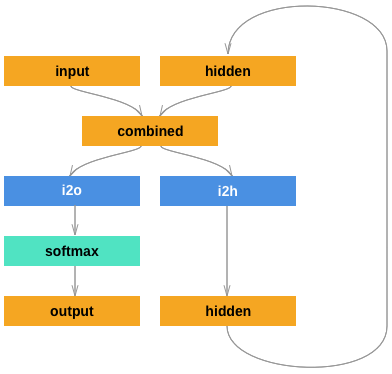

In [37]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_genres)

このネットワークのステップを実行するには、入力データ（ここでは、現在の文字のテンソル）と、一つ前の文字の隠れ状態（最初はゼロで初期化）を渡す必要があります。

実際に実行すると、出力（各言語の確率）と、次のステップでの予測の際に与えるRNNの隠れ状態を取得することができます。

In [38]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

計算効率上、学習ステップごとに新しいテンソルを作成することは避けたいです。

そこで`letterToTensor`の代わりに、`lineToTensor`を使用し、まず一度単語のテンソルを作成します。

そしてスライスを使い、単語のテンソルから各文字のテンソルを取得します。

さらに効率的にするために、単語ではなく、バッチのテンソルを事前に計算しておく方法もあります。

In [39]:
input = lineToTensor('Doraemon')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.1513, -3.0619, -3.0916, -3.0701, -3.1322, -3.1191, -3.0320, -3.1338,
         -3.1833, -3.0645, -3.1255, -2.9932, -2.9957, -3.1649, -3.0341, -3.0970,
         -3.1178, -3.0819, -3.1407, -3.0887, -3.1454, -3.0100]],
       grad_fn=<LogSoftmaxBackward0>)


ご覧のように、出力は`<1 x n_categories>`のテンソルとなり、各項目はそのカテゴリ（苗字の言語）に対する尤度です（0に近いほどそのカテゴリに属する可能性が高くなります）。

訓練
========
訓練の準備
----------------------

訓練に入る前に、いくつかの補助関数（ヘルパー関数）を作る必要があります。

一つ目は、ネットワークの出力を解釈するための関数です。

テンソルにおける最大値のインデックスを得るために`Tensor.topk`を使うことができます。





In [40]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return genres_list[category_i], category_i

print(categoryFromOutput(output))

('Slice of Life', 11)


また、訓練用にデータの具体例（苗字とその言語）を簡単に取得して、提示する関数もあると便利です。

In [41]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    genre = randomChoice(genres_list)
    anime_titles = anime[anime['Genres'].str.contains(genre, case=False)]['Name']

    line = randomChoice(anime_titles.to_list())
    genre_tensor = torch.tensor(genres_list.index(genre), dtype=torch.long)
    line_tensor = lineToTensor(line)
    return genre, line, genre_tensor, line_tensor


for i in range(10):
    genre, line, genre_tensor, line_tensor = randomTrainingExample()
    print('genre =', genre, '/ line =', line)
    print(genre_tensor)
    print(line_tensor.size())


genre = Supernatural / line = Kamishibai Itazura Tanuki no Maki
tensor(6)
torch.Size([33, 1, 57])
genre = Adventure / line = Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsuyoi Yatsu
tensor(3)
torch.Size([55, 1, 57])
genre = Slice of Life / line = Yume-iro Pâtissière SP Professional
tensor(11)
torch.Size([35, 1, 57])
genre = Comedy / line = Naruto: Akaki Yotsuba no Clover wo Sagase
tensor(9)
torch.Size([41, 1, 57])
genre = Horror / line = Guai Zai
tensor(16)
torch.Size([8, 1, 57])
genre = Romance / line = Kindan Joshi
tensor(10)
torch.Size([12, 1, 57])
genre = Award Winning / line = Kai Douryoku Real
tensor(1)
torch.Size([17, 1, 57])
genre = UNKNOWN / line = Future Card Buddyfight Recap
tensor(20)
torch.Size([28, 1, 57])
genre = Mystery / line = Zankyou no Terror
tensor(5)
torch.Size([17, 1, 57])
genre = Horror / line = Devilman: Crybaby - Digest Eizou
tensor(16)
torch.Size([32, 1, 57])


ネットワークの訓練
----------------------

このネットワークの訓練に必要なプロセスは、多くの正解付きデータ（アノテーション付きの教師データ）を入力して推論させ、推論結果の良否をフィードバックすることです。

RNNの最後の層は`nn.LogSoftmax`なので、対応する損失関数は`nn.NLLLoss`となります。

In [42]:
criterion = nn.NLLLoss()

訓練のループは以下に示す順番で進みます。

- 入力テンソルと正解テンソルを作成
- 初期の隠れ状態（値はゼロ）の作成
- それぞれの文字を読み込み、
  - 次の文字のために隠れ状態を保持
- 最終出力を正解と比較
- 誤差逆伝播
- 出力と損失を返す

In [44]:
import torch.optim as optim


learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

# オプティマイザを定義（例：SGDオプティマイザ）
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
import torch.optim as optim

# オプティマイザを定義（例：SGDオプティマイザ）


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    category_tensor = category_tensor.view(1).type(torch.LongTensor)  # バッチサイズ1の整数型テンソルに変換
    loss = criterion(output, category_tensor)
    loss.backward()
    print(loss)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        if p.data is None:
            continue
        p.data.add_(p.grad.data, alpha=-learning_rate)
    # 勾配がNoneでないことを確認するデバッグ出力
    # for p in rnn.parameters():
    #     if p.grad is None:
    #         print(f"Parameter {p} has no gradient.")
    #     else:
    #         print(f"Parameter {p} gradient size: {p.grad.size()}")

    # オプティマイザでパラメータを更新する
    # optimizer.step()

    return output, loss.item()

あとは、大量のサンプルデータを使用して訓練ループを実行するだけです。

`train`関数は出力と損失の両方を返すので、推論結果を表示したり、プロットするために損失を求めることができます。

数千のデータがあるので、`print_every`で、指定したイテレーションごとに損失の平均を求め、print文で出力します。

In [45]:
import time
import math

n_iters = 1000
print_every = 100
plot_every = 100



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print(f'{iter} {iter / n_iters * 100}% ({timeSince(start)}) {loss:.4f} {line} / {guess} {correct}')

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

tensor(3.1019, grad_fn=<NllLossBackward0>)
tensor(3.1085, grad_fn=<NllLossBackward0>)
tensor(3.1222, grad_fn=<NllLossBackward0>)
tensor(3.0886, grad_fn=<NllLossBackward0>)
tensor(3.0288, grad_fn=<NllLossBackward0>)
tensor(3.1039, grad_fn=<NllLossBackward0>)
tensor(3.1414, grad_fn=<NllLossBackward0>)
tensor(3.1360, grad_fn=<NllLossBackward0>)
tensor(3.1599, grad_fn=<NllLossBackward0>)
tensor(3.2143, grad_fn=<NllLossBackward0>)
tensor(3.1229, grad_fn=<NllLossBackward0>)
tensor(3.0817, grad_fn=<NllLossBackward0>)
tensor(3.1938, grad_fn=<NllLossBackward0>)
tensor(3.0567, grad_fn=<NllLossBackward0>)
tensor(3.0627, grad_fn=<NllLossBackward0>)
tensor(3.0894, grad_fn=<NllLossBackward0>)
tensor(3.1931, grad_fn=<NllLossBackward0>)
tensor(3.1763, grad_fn=<NllLossBackward0>)
tensor(3.1536, grad_fn=<NllLossBackward0>)
tensor(3.1354, grad_fn=<NllLossBackward0>)
tensor(3.1822, grad_fn=<NllLossBackward0>)
tensor(3.0179, grad_fn=<NllLossBackward0>)
tensor(3.1444, grad_fn=<NllLossBackward0>)
tensor(3.22

結果のプロット
--------------------

`all_losses`から過去の損失をプロットすると、ネットワーク学習の様子がわかります

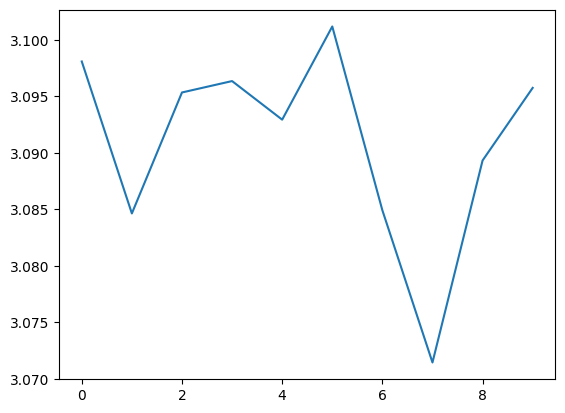

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

結果の評価
======================

ネットワークが各カテゴリ（言語）に対して、どの程度の性能を発揮しているのかを確認するために、実際の言語（=行）ごとに、ネットワークの推論結果がどの言語だったのか（列）を示す、混同行列（confusion matrix）を作成します。

混同行列を計算するために、`evaluate()`関数を用いて多くのサンプルを入力としてネットワークを実行しますが、この`evaluate()`関数は、逆伝播を実行しない`train()`関数と同義です。


In [47]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_genres, n_genres)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = genres_list.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_genres):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + genres_list, rotation=90)
ax.set_yticklabels([''] + genres_list)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

斜めの軸の点の明るさから、どの言語で推測結果に間違いが多いか分かります

（日本語訳注：点が暗いほどその言語に対する予測結果は間違いが多く、明るいほど正解が多いことを示しています）。

例えば、ギリシャ語では非常に良く、英語では非常に悪いようです（これはおそらく、英語の苗字は他の言語との重複が多いためでしょう）。

ユーザーが入力した苗字に対する推論実行
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, genres_list[category_index]))
            predictions.append([value, genres_list[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.78) Russian
(-1.01) Czech
(-2.66) Polish

> Jackson
(-0.97) Scottish
(-1.46) English
(-1.87) French

> Satoshi
(-1.31) Japanese
(-1.44) Italian
(-1.58) Arabic


In [ ]:
# 日本語訳追記：[1] 上記の結果は実行の度に変わります。[2] 今回は検証のデータセットを用意していないので、過学習する恐れがあります。

# 田中で試す
predict('Saito')



> Saito
(-0.90) Portuguese
(-1.40) Japanese
(-1.78) Italian


[in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)にあるスクリプトの最終バージョンでは、上記のコードをいくつかのファイルに分割しています。

- `data.py` (データファイルのロード)
- `model.py` (RNNの定義)
- `train.py` (トレーニングの実行)
- `predict.py` (コマンドライン引数で `predict()` の実行)
- `server.py` (bottle.pyを用いたJSON APIとしての推論結果提供)

ネットワークを訓練して保存するには `train.py` を実行してください。

予測結果を表示するには、名前を付けて `predict.py` を実行してください。

```:cmd
    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech
```

`server.py`を実行し、 http://localhost:5533/Yournameto にアクセスして予測結果のJSONを取得してください。



演習
=========

- 本チュートリアルで使ったデータとは異なる、行 -> カテゴリ を判定するデータセットで試してみてください。例えば、以下などです。

   - 任意の単語 -> 言語
   - 下の名前 -> 性別
   - キャラクター名 -> 著者
   - ページタイトル -> ブログまたはウェブページ

- ネットワークを大きくしたり、またはネットワークの構造を改善したりして、さらに良い結果を目指してください。例えば、以下のような改善が考えられます。

   - より多くの線形レイヤーを追加
   - `nn.LSTM` と `nn.GRU` のレイヤーを試す
   - 上記のような複数の`RNN`を、組み合わせた高次元のネットワークを試す

